<a href="https://colab.research.google.com/github/LEPK02/tensorflow/blob/main/Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EPL 18-19 Season
Data analysis of the EPL football season.

Dataset provided by [FootyStats](https://footystats.org/download-stats-csv#whats_included).

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# Players' database - import and clean
players_main_db = pd.read_csv("https://raw.githubusercontent.com/LEPK02/tensorflow/main/england-premier-league-players-2018-to-2019-stats.csv")
players_main_db.drop(["league", "season", "birthday", "birthday_GMT"], axis=1, inplace=True)
players_main_db.rename(columns={'Current Club':'current_club'}, inplace=True)
players_main_db.head()

# Clean data
# players_main_db.isna().sum()
# players_main_db = players_main_db.dropna()

,full_name,age,position,current_club,minutes_played_overall,minutes_played_home,minutes_played_away,nationality,appearances_overall,appearances_home,...,conceded_per_90_overall,min_per_conceded_overall,min_per_match,min_per_card_overall,min_per_assist_overall,cards_per_90_overall,rank_in_league_top_attackers,rank_in_league_top_midfielders,rank_in_league_top_defenders,rank_in_club_top_scorer
0,Aaron Cresswell,32,Defender,West Ham United,1589,888,701,England,20,11,...,1.25,72,79,1589,1589,0.06,290,191,80,20
1,Aaron Lennon,34,Midfielder,Burnley,1217,487,730,England,16,7,...,1.48,61,76,1217,1217,0.07,196,187,-1,10
2,Aaron Mooy,31,Midfielder,Huddersfield Town,2327,1190,1137,Australia,29,15,...,1.78,51,80,582,2327,0.15,144,233,-1,3
3,Aaron Ramsey,31,Midfielder,Arsenal,1327,689,638,Wales,28,14,...,0.81,111,47,0,221,0.00,69,8,-1,5
4,Aaron Rowe,21,Forward,Huddersfield Town,69,14,55,England,2,1,...,1.30,69,35,0,0,0.00,-1,-1,-1,31


In [ ]:
# Teams' database
teams_main_db = pd.read_csv("https://raw.githubusercontent.com/LEPK02/tensorflow/main/england-premier-league-teams-2018-to-2019-stats.csv")

teams_main_db.head()  

,team_name,common_name,season,country,matches_played,matches_played_home,matches_played_away,suspended_matches,wins,wins_home,...,goals_conceded_min_61_to_70,goals_conceded_min_71_to_80,goals_conceded_min_81_to_90,draw_percentage_overall,draw_percentage_home,draw_percentage_away,loss_percentage_ovearll,loss_percentage_home,loss_percentage_away,over145_corners_percentage
0,Arsenal FC,Arsenal,2018/2019,England,38,19,19,0,21,14,...,12,1,8,18,16,21,26,11,42,5
1,Tottenham Hotspur FC,Tottenham Hotspur,2018/2019,England,38,19,19,0,23,12,...,4,8,10,5,11,0,34,26,42,11
2,Manchester City FC,Manchester City,2018/2019,England,38,19,19,0,32,18,...,4,2,3,5,0,11,11,5,16,5
3,Leicester City FC,Leicester City,2018/2019,England,38,19,19,0,15,8,...,7,1,9,18,16,21,42,42,42,5
4,Crystal Palace FC,Crystal Palace,2018/2019,England,38,19,19,0,14,5,...,8,8,11,18,26,11,45,47,42,11


##Linear Regression

Guess a player's ranking based on the others'.

In [ ]:
# NUMERIC_COLUMNS = ["age", "minutes_played_overall", "minutes_played_home", "minutes_played_away", "appearances_overall", "appearances_home", "appearances_away", "goals_overall", "goals_home", "goals_away", "assists_overall", "assists_home", "assists_away", "penalty_goals", "penalty_misses", "clean_sheets_overall", "clean_sheets_home", "clean_sheets_away", "conceded_overall", "conceded_home", "conceded_away", "yellow_cards_overall", "red_cards_overall", "goals_involved_per_90_overall", "assists_per_90_overall", "goals_per_90_overall", "goals_per_90_home", "goals_per_90_away", "min_per_goal_overall", "conceded_per_90_overall", "min_per_conceded_overall", "min_per_match", "min_per_card_overall", "min_per_assist_overall", "cards_per_90_overall", "rank_in_league_top_attackers", "rank_in_league_top_midfielders", "rank_in_club_top_scorer"]
# CATEGORICAL_COLUMNS = ["current_club"]

In [ ]:
# Filter defenders with minimum 900 minutes
defenders = players_main_db[
    (players_main_db.rank_in_league_top_defenders != -1) &
    (players_main_db.position == "Defender") &
    (players_main_db.minutes_played_overall >= 900)
] \
  .sort_values(by=["rank_in_league_top_defenders"]) \
  .reset_index(drop=True)

# Drop redundant columns
defenders.drop(["position", "nationality", "full_name"], axis=1, inplace=True)

# Encode categorical data
defenders['current_club'] = defenders['current_club'].map({
    'West Ham United': 1,
    'Burnley': 2,
    'Huddersfield Town': 3,
    'Arsenal': 4,
    'Crystal Palace': 5,
    'Watford': 6,
    'Fulham': 7,
    'Liverpool': 8,
    'AFC Bournemouth': 9,
    'Wolverhampton Wanderers': 10,
    'Everton': 11,
    'Leicester City': 12,
    'Southampton': 13,
    'Cardiff City': 14,
    'Manchester United': 15,
    'Tottenham Hotspur': 16,
    'Brighton & Hove Albion': 17,
    'Chelsea': 18,
    'Newcastle United': 19,
    'Manchester City': 20
})
defenders = pd.get_dummies(defenders, columns=['current_club'], prefix='', prefix_sep='')

In [ ]:
# defenders_training.describe().transpose()

In [ ]:
# Split training and test set
defenders_training = defenders.sample(frac=0.8, random_state=0)
defenders_test = defenders.drop(defenders_training.index)

# Split features from labels
train_features = defenders_training.copy()
test_features = defenders_test.copy()

train_labels = train_features.pop('rank_in_league_top_defenders')

test_labels = test_features.pop('rank_in_league_top_defenders')

One Variable

In [ ]:
# Create array with only conceded_per_90_overall
concede = np.array(train_features['conceded_per_90_overall'])

# Normalize the input
concede_normalizer = layers.Normalization(input_shape=[1,], axis=None)
concede_normalizer.adapt(concede)

In [ ]:
# Build the Keras Sequential model
concede_model = tf.keras.Sequential([
    concede_normalizer,
    layers.Dense(units=1)
])

concede_model.summary()

# Test untrained model on first 10 values
concede_model.predict(concede[:10])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


array([[-0.293],
       [ 1.201],
       [ 1.201],
       [-2.351],
       [ 1.267],
       [-1.056],
       [-2.517],
       [-2.285],
       [-0.392],
       [ 0.935]], dtype=float32)

In [ ]:
# Configure training procedure
concede_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [ ]:
# Train using 100 epochs
history = concede_model.fit(
    train_features['conceded_per_90_overall'],
    train_labels,
    epochs=100,
    verbose=0, # suppress logging
    validation_split = 0.2 # calculate validation results on 20% of the training data
)

In [ ]:
# Store results
test_results = {}
test_results['concede_model'] = concede_model.evaluate(
    test_features['conceded_per_90_overall'],
    test_labels, verbose=0)

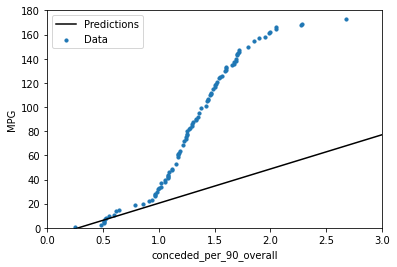

In [ ]:
# Visualise the data
x = tf.linspace(0.0, 250, 251)
y = concede_model.predict(x)

def plot_horsepower(x, y):
  plt.scatter(
      train_features['conceded_per_90_overall'], 
      train_labels,
      label='Data',
      s=10
  )
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('conceded_per_90_overall')
  plt.ylabel('MPG')
  plt.xlim(0, 3)
  plt.ylim(0, 180)
  plt.legend()

plot_horsepower(x, y)

Multiple Variables

In [ ]:
# Create feature normalizer
normalizer = tf.keras.layers.Normalization(axis=-1)

# Fit the state of the preprocessing layer to the data
normalizer.adapt(np.array(train_features))

# Store mean and variance in the layer
normalizer.mean.numpy()

# Create two-step sequential model with normalizer as the first layer
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

# Model.predict produces 1 output for each example (10 shown below)
# linear_model.predict(train_features[:10]) 

# Check kernel weights, expected shape = (58, 1)
linear_model.layers[1].kernel

# Configure the model with Keras
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error'
)

# Train with Model.fit for 100 epochs
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0, # suppress logging
    validation_split = 0.2 # calculate validation results on 20% of the training data.
)

In [ ]:
test_results['linear_model'] = linear_model.evaluate(
    test_features,
    test_labels,
    verbose=0)
print(test_results)

{'concede_model': 60.58127212524414, 'linear_model': 63.47819900512695}
